# 2km temp and precip preprocessing

This notebook contains code for preprocessing the 2km IEM temperature and precip data in SNAP's holdings for ingest into Rasdaman. It currently clips GeoTIFFs to the IEM extent and writes them to a new folder.

The raster data of interest live in CKAN at:
- `Base/AK_CAN_2km/projected/AR5_CMIP5_models/Projected_Monthy_and_Derived_Temperature_Products_2km_CMIP5_AR5/derived`
- `Base/AK_CAN_2km/projected/AR5_CMIP5_models/Projected_Monthy_and_Derived_Precipitation_Products_2km_CMIP5_AR5/derived`
- `Base/AK_CAN_2km/historical/CRU_TS/Historical_Monthly_and_Derived_Precipitation_Products_2km_CRU_TS`
- `Base/AK_CAN_2km/historical/CRU_TS/Historical_Monthly_and_Derived_Temperature_Products_2km_CRU_TS`

The code cells for processing the CRU data and monthly AR5 data have been removed, as the only data for the IEM-webapp proejct that this preprocessing applies to is the AR5 decadal seasonal data. It should be trivial to preprocess these data sources using this notebook if needed.

## Setup

1. The AR5 GeoTIFFs need to be in a single folder for each variable, and each folder should be in the same directory. That directory may be stored in the `$SCRATCH_DIR` environment variable or may be set in the cell below. This directory is also used for making a `tmp` directory for intermediate files for clipping to the IEM domain.
2. The shapefile for the IEM domain can be found in the [geospatial-vector-veractiy](https://github.com/ua-snap/geospatial-vector-veracity/blob/706c56855885165eab2c4817e8ca8a4ffb9d751a/vector_data/polygon/boundaries/iem/AIEM_domain.shp) repo. Clone this repo and change the input path as needed in the following code cell, or set the `$GVV_DIR` environment variable.

Clipped rasters will be written to a single output folder with the name of the workding data directory plus the suffix `_iem_domain`.

In [1]:
import os
from pathlib import Path

# set paths to datasets and geospatial-vector-veractiy repo
scratch_path = os.getenv("SCRATCH_DIR") or "/atlas_scratch/kmredilla/iem-webapp"
gvv_path = os.getenv("GVV_DIR") or "/workspace/UA/kmredilla/geospatial-vector-veracity"

scratch_dir = Path(scratch_path)
gvv_dir = Path(gvv_path)

In [2]:
import geopandas as gpd

# read shapefile of IEM domain
# copied from cloned geospatial-vector-veracity repo
aiem_domain_gdf = gpd.read_file(gvv_dir.joinpath("vector_data/polygon/boundaries/iem_with_ak_aleutians/iem_with_ak_aleutians.shp"))

bounds = {bound: value for bound, value in zip(["wb", "sb", "eb", "nb"], aiem_domain_gdf.bounds.values[0])}

In [3]:
import rasterio as rio
from rasterio.windows import Window

# open a single file to get the row/column values for 
# windowed reading using the domain extent bounds
fp = list(scratch_dir.joinpath("ar5_2km_tas_decadal_seasonal").glob("*.tif"))[0]
with rio.open(fp) as src:
    row_start = src.index(bounds["wb"], bounds["nb"])[0]
    row_stop = src.index(bounds["wb"], bounds["sb"])[0]
    col_start = src.index(bounds["wb"], bounds["sb"])[1]
    col_stop = src.index(bounds["eb"], bounds["sb"])[1]
    # also save metadata for later
    tmp_meta = src.meta.copy()
    # create the window object for reuse
    window = Window.from_slices(slice(row_start, row_stop), slice(col_start, col_stop))
    # get the window transform for the windowed reading
    window_transform = src.window_transform(window)
    arr = src.read(1, window=window)
    height, width = arr.shape[-2:]

tmp_meta.update({"transform": window_transform, "height": height, "width": width})

# setup tmp dir for writing intermediate files
tmp_dir = scratch_dir.joinpath("tmp")
tmp_dir.mkdir(exist_ok=True)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from rasterio.mask import mask
from tqdm.notebook import tqdm

def clip_raster(args):
    """Clip a raster to clip_poly, crop to extent, 
    and write to out_dir with same filename
    """
    in_fp, window, tmp_meta, tmp_dir, clip_poly, out_dir = args
    tmp_fp = tmp_dir.joinpath(in_fp.name)
    tmp_fp.unlink(missing_ok=True)
    # to match what was done for the CRU data, write 
    # the windowed read of the data to a tmp file 
    with rio.open(in_fp) as src:
        with rio.open(tmp_fp, "w", **tmp_meta) as dst:
            dst.write(src.read(window=window)[0], 1)
    # then open it and mask
    with rio.open(tmp_fp) as src:
        arr, new_transform = mask(src, clip_poly, crop=True)
        new_meta = src.meta.copy()
    
    new_meta.update({"transform": new_transform, "height": arr.shape[1], "width": arr.shape[2]})
    out_fp = out_dir.joinpath(tmp_fp.name.replace(".tif", "_iem_domain.tif"))
    # delete file before re-writing
    out_fp.unlink(missing_ok=True)
    with rio.open(out_fp, "w", **new_meta) as dst:
        dst.write(arr[0], 1)
        
    return out_fp


def clip_iem_rasters(src_dir, window, tmp_meta, tmp_dir, clip_poly, ncpus=32):
    """Supply the path to directory containing the GeoTIFFs to be clipped"""
    fps = src_dir.glob("*.tif")
    out_dir = Path(f"{str(src_dir)}_iem_domain")
    out_dir.mkdir(exist_ok=True)
    
    args = [(fp, window, tmp_meta, tmp_dir, clip_poly, out_dir) for fp in fps]

    out_fps = []
    # trying tqdm for progress bar
    with Pool(ncpus) as pool:
        for out in tqdm(pool.imap(clip_raster, args), total=len(args)):
            out_fps.append(out)

    print(f"All IEM rasters clipped and written to {out_dir}")
    
    return out_fps
    

def plot_sample_tif(fp):
    with rio.open(fp) as src:
        arr = src.read(1)
        print("meta: ", src.meta)
        
    arr[arr == src.meta["nodata"]] = np.nan
    plt.imshow(arr, interpolation="none")


## Seasonal ingest

In [5]:
src_fn = "ar5_2km_pr_decadal_seasonal"
src_dir = scratch_dir.joinpath(src_fn)
ar5_seasonal_pr_fps = clip_iem_rasters(src_dir, window, tmp_meta, tmp_dir, aiem_domain_gdf.geometry)

  0%|          | 0/324 [00:00<?, ?it/s]

All IEM rasters clipped and written to /atlas_scratch/kmredilla/iem-webapp/ar5_2km_pr_decadal_seasonal_iem_domain


meta:  {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 1995, 'height': 982, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(2000.0, 0.0, -2169223.206087799,
       0.0, -2000.0, 2380412.932644147)}


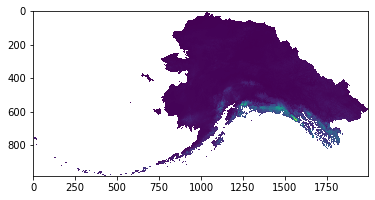

In [6]:
plot_sample_tif(ar5_seasonal_pr_fps[0])

In [7]:
src_fn = "ar5_2km_tas_decadal_seasonal"
src_dir = scratch_dir.joinpath(src_fn)
ar5_seasonal_tas_fps = clip_iem_rasters(src_dir, window, tmp_meta, tmp_dir, aiem_domain_gdf.geometry)

  0%|          | 0/324 [00:00<?, ?it/s]

All IEM rasters clipped and written to /atlas_scratch/kmredilla/iem-webapp/ar5_2km_tas_decadal_seasonal_iem_domain


meta:  {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 1995, 'height': 982, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(2000.0, 0.0, -2169223.206087799,
       0.0, -2000.0, 2380412.932644147)}


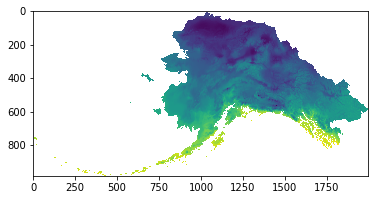

In [8]:
plot_sample_tif(ar5_seasonal_tas_fps[0])